# Import và Cấu hình

In [1]:
import psycopg2
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import os
from dotenv import load_dotenv

# Load biến môi trường từ .env
load_dotenv()

# Cấu hình hiển thị biểu đồ đẹp hơn
sns.set(style='whitegrid')
%matplotlib inline

# Cấu hình thiết bị (Ưu tiên GPU nếu có, không thì dùng CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Đang sử dụng thiết bị: {device}")

✅ Đang sử dụng thiết bị: cuda


# Tải dữ liệu từ PostgreSQL

In [2]:
# Cấu hình Database từ .env
DB_CONFIG = {
    "dbname": os.getenv("POSTGRES_DB"),
    "user": os.getenv("POSTGRES_USER"),
    "password": os.getenv("POSTGRES_PASSWORD"),
    "host": os.getenv("DB_HOST", "localhost"),
    "port": os.getenv("DB_PORT", "5432")
}

# Kiểm tra config
if not DB_CONFIG["dbname"]:
    print("❌ LỖI: Không đọc được file .env")
    raise ValueError("Thiếu cấu hình database trong .env")

print(f"📊 Kết nối tới database: {DB_CONFIG['dbname']} @ {DB_CONFIG['host']}")

# Kết nối Database
print("⏳ Đang tải dữ liệu từ PostgreSQL...")
conn = psycopg2.connect(**DB_CONFIG)

# Truy vấn từ bảng 'articles' (không phải 'news_articles')
query = "SELECT embedding, label FROM articles WHERE label IS NOT NULL AND embedding IS NOT NULL"

# Load vào DataFrame
df = pd.read_sql(query, conn)
conn.close()

print(f"📊 Tổng số bản ghi: {len(df)}")
print(f"📊 Phân bố labels:")
print(df['label'].value_counts())

print("\n⏳ Đang chuyển đổi chuỗi vector sang mảng NumPy (có thể mất vài giây)...")

# Chuyển đổi cột embedding từ String -> Numpy Array
import ast
df['embedding'] = df['embedding'].apply(lambda x: np.array(ast.literal_eval(x) if isinstance(x, str) else x, dtype=np.float32))

# Tách Feature (X) và Label (y)
X = np.stack(df['embedding'].values)
y = df['label'].values

print(f"✅ Kích thước X: {X.shape}")
print(f"✅ Kích thước y: {y.shape}")
print(f"✅ Vector dimension: {X.shape[1]}")

📊 Kết nối tới database: vnexpress_scraper @ localhost
⏳ Đang tải dữ liệu từ PostgreSQL...


/tmp/ipykernel_37639/572163047.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


📊 Kết nối tới database: vnexpress_scraper @ localhost
⏳ Đang tải dữ liệu từ PostgreSQL...


/tmp/ipykernel_37639/572163047.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


📊 Tổng số bản ghi: 98838
📊 Phân bố labels:
label
0    49803
1    49035
Name: count, dtype: int64

⏳ Đang chuyển đổi chuỗi vector sang mảng NumPy (có thể mất vài giây)...
✅ Kích thước X: (98838, 768)
✅ Kích thước y: (98838,)
✅ Vector dimension: 768
✅ Kích thước X: (98838, 768)
✅ Kích thước y: (98838,)
✅ Vector dimension: 768


# Chia tập Train/Val/Test

Chia Dataset làm 3 phần:
- Train (70%): Để học.
- Validation (15%): Để chấm điểm sau mỗi epoch (vẽ biểu đồ).
- Test (15%): Để đánh giá lần cuối cùng.

In [3]:
# Chia Train (85%) và Test (15%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Chia tiếp Train (70% tổng) và Validation (15% tổng)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.176, random_state=42) 

# Chuyển sang Tensor và đưa vào DataLoader
batch_size = 64

train_dataset = TensorDataset(torch.from_numpy(X_train).to(device), torch.from_numpy(y_train).to(device))
val_dataset = TensorDataset(torch.from_numpy(X_val).to(device), torch.from_numpy(y_val).to(device))
test_dataset = TensorDataset(torch.from_numpy(X_test).to(device), torch.from_numpy(y_test).to(device))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"🔹 Train set: {len(X_train)}")
print(f"🔹 Val set:   {len(X_val)}")
print(f"🔹 Test set:  {len(X_test)}")

🔹 Train set: 69225
🔹 Val set:   14787
🔹 Test set:  14826


# Xây dựng Model và Hàm Train

In [4]:
class NewsClassifier(nn.Module):
    def __init__(self, input_dim):
        super(NewsClassifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )
    
    def forward(self, x):
        return self.network(x)

model = NewsClassifier(input_dim=X.shape[1]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Hàm tính độ chính xác
def calculate_accuracy(y_pred, y_true):
    _, predicted = torch.max(y_pred, 1)
    correct = (predicted == y_true).sum().item()
    return correct / y_true.size(0)

# --- TRAINING LOOP ---
epochs = 15
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

print("🚀 Bắt đầu training...")
print(f"📊 Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"🔹 Training trên {device}")
print(f"🔹 Batch size: {batch_size}")
print(f"🔹 Epochs: {epochs}\n")

for epoch in range(epochs):
    # Train
    model.train()
    train_loss, train_acc = 0, 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_acc += calculate_accuracy(outputs, y_batch)
    
    # Validate
    model.eval()
    val_loss, val_acc = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            val_acc += calculate_accuracy(outputs, y_batch)
    
    # Tính trung bình
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    avg_train_acc = train_acc / len(train_loader)
    avg_val_acc = val_acc / len(val_loader)
    
    # Lưu lịch sử
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['train_acc'].append(avg_train_acc)
    history['val_acc'].append(avg_val_acc)
    
    print(f"Epoch {epoch+1:02d}/{epochs} | Train Loss: {avg_train_loss:.4f} | Train Acc: {avg_train_acc*100:.2f}% | Val Loss: {avg_val_loss:.4f} | Val Acc: {avg_val_acc*100:.2f}%")

print("\n🎉 Training hoàn tất!")
print("💾 Đang lưu model...")

# Lưu vào thư mục model (để FastAPI dùng)
torch.save(model.state_dict(), "fakenews_classifier.pth")
print(f"✅ Đã lưu: fakenews_classifier.pth")

🚀 Bắt đầu training...
📊 Model parameters: 230,018
🔹 Training trên cuda
🔹 Batch size: 64
🔹 Epochs: 15

Epoch 01/15 | Train Loss: 0.0780 | Train Acc: 97.15% | Val Loss: 0.0363 | Val Acc: 98.67%
Epoch 01/15 | Train Loss: 0.0780 | Train Acc: 97.15% | Val Loss: 0.0363 | Val Acc: 98.67%
Epoch 02/15 | Train Loss: 0.0330 | Train Acc: 98.85% | Val Loss: 0.0372 | Val Acc: 98.73%
Epoch 02/15 | Train Loss: 0.0330 | Train Acc: 98.85% | Val Loss: 0.0372 | Val Acc: 98.73%
Epoch 03/15 | Train Loss: 0.0246 | Train Acc: 99.16% | Val Loss: 0.0231 | Val Acc: 99.29%
Epoch 03/15 | Train Loss: 0.0246 | Train Acc: 99.16% | Val Loss: 0.0231 | Val Acc: 99.29%
Epoch 04/15 | Train Loss: 0.0199 | Train Acc: 99.28% | Val Loss: 0.0202 | Val Acc: 99.26%
Epoch 04/15 | Train Loss: 0.0199 | Train Acc: 99.28% | Val Loss: 0.0202 | Val Acc: 99.26%
Epoch 05/15 | Train Loss: 0.0164 | Train Acc: 99.43% | Val Loss: 0.0285 | Val Acc: 99.18%
Epoch 05/15 | Train Loss: 0.0164 | Train Acc: 99.43% | Val Loss: 0.0285 | Val Acc: 99.18

# Vẽ biểu đồ quá trình học (Learning Curves)

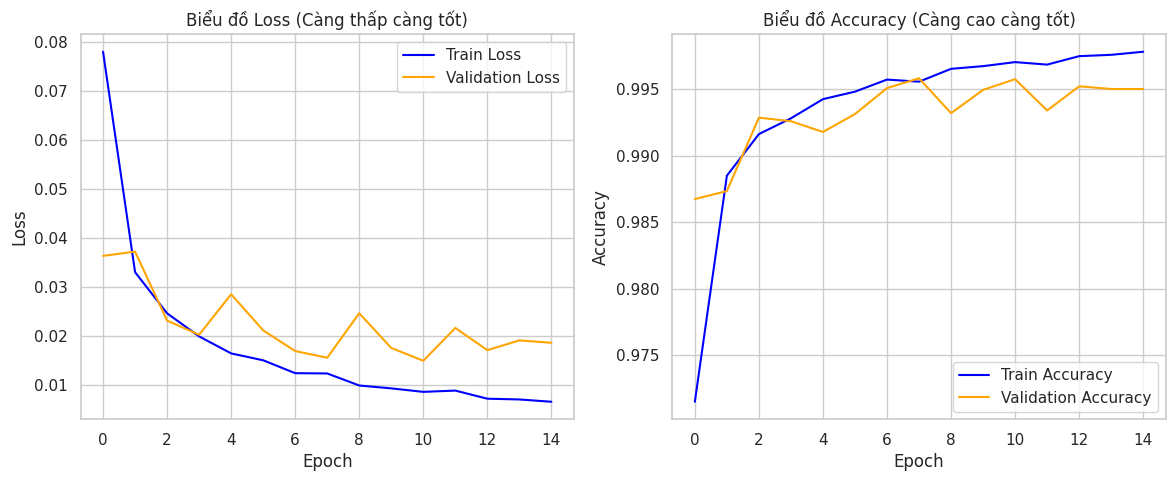

In [5]:
plt.figure(figsize=(14, 5))

# Biểu đồ 1: Loss (Sai số)
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss', color='blue')
plt.plot(history['val_loss'], label='Validation Loss', color='orange')
plt.title('Biểu đồ Loss (Càng thấp càng tốt)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Biểu đồ 2: Accuracy (Độ chính xác)
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy', color='blue')
plt.plot(history['val_acc'], label='Validation Accuracy', color='orange')
plt.title('Biểu đồ Accuracy (Càng cao càng tốt)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Đánh giá chi tiết bằng Confusion Matrix

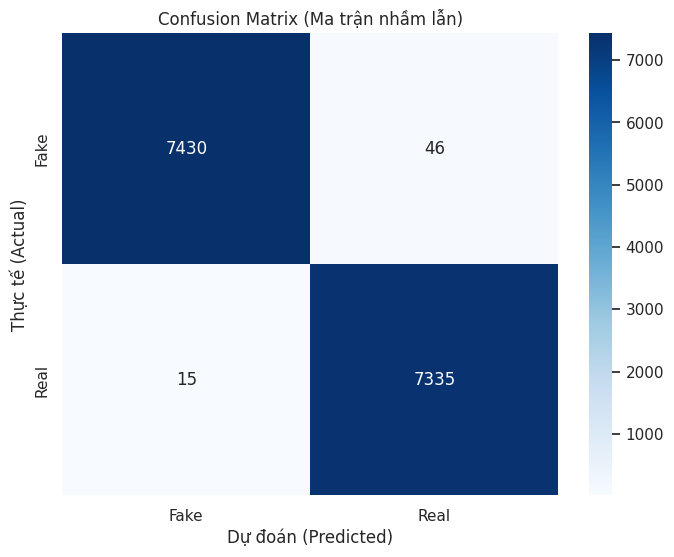

              precision    recall  f1-score   support

        Fake       1.00      0.99      1.00      7476
        Real       0.99      1.00      1.00      7350

    accuracy                           1.00     14826
   macro avg       1.00      1.00      1.00     14826
weighted avg       1.00      1.00      1.00     14826



In [6]:
# Dự đoán trên tập Test (Tập dữ liệu chưa từng gặp)
model.eval()
y_pred_list = []
y_true_list = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        y_pred_list.extend(preds.cpu().numpy())
        y_true_list.extend(y_batch.cpu().numpy())

# Vẽ Confusion Matrix
cm = confusion_matrix(y_true_list, y_pred_list)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Dự đoán (Predicted)')
plt.ylabel('Thực tế (Actual)')
plt.title('Confusion Matrix (Ma trận nhầm lẫn)')
plt.show()

# In báo cáo chi tiết
print(classification_report(y_true_list, y_pred_list, target_names=['Fake', 'Real']))